In [1]:
import librosa
import librosa.display
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,AveragePooling2D,ZeroPadding2D,BatchNormalization

Using TensorFlow backend.


In [160]:
y, sr = librosa.load('/home/daniel/datatest/nine/d8ee4734_nohash_0.wav',sr=16000,duration=10)

In [161]:
print y

[ 5.4931641e-04  9.4604492e-04  3.9672852e-04 ... -3.3569336e-04
  9.1552734e-05  5.4931641e-04]


In [162]:
plt.figure(figsize=(12, 8))
D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

/home/daniel/anaconda/lib/python2.7/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


In [163]:
plt.subplot(4, 2, 2)
librosa.display.specshow(D, y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')

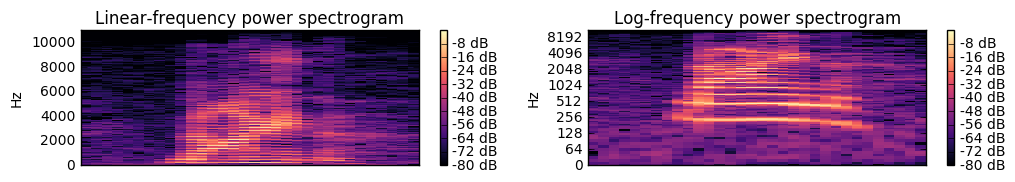

In [164]:
plt.show()

In [2]:
DATA_PATH = "/home/daniel/data/"

In [3]:
# Input: Folder Path
# Output: Tuple (Label, Indices of the labels, one-hot encoded labels)
def get_labels(path=DATA_PATH):
    labels = os.listdir(path)
    label_indices = np.arange(0, len(labels))
    return labels, label_indices, to_categorical(label_indices)

In [4]:
import numpy as np
import os

DATA_PATH = "/home/daniel/data/"

# Input: Folder Path
# Output: Tuple (Label, Indices of the labels, one-hot encoded labels)
def get_labels(path=DATA_PATH):
    labels = os.listdir(path)
    label_indices = np.arange(0, len(labels))
    return labels, label_indices, to_categorical(label_indices)


In [5]:
labels, _, _ = get_labels(DATA_PATH)
labels

['marvin',
 'happy',
 'six',
 'up',
 'stop',
 'yes',
 'sheila',
 'zero',
 'dog',
 'right',
 'house',
 'no',
 'two',
 'left',
 'cat',
 'nine',
 'seven',
 'three',
 'wow',
 'bed']

In [6]:
# Handy function to convert wav2mfcc
def wav2mfcc(file_path, max_len=11):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    wave = wave[::3]
    mfcc = librosa.feature.mfcc(wave, sr=16000)

    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]
    
    return mfcc

In [7]:
def save_data_to_array(path=DATA_PATH, max_len=11):
    labels, _, _ = get_labels(path)

    for label in labels:
        # Init mfcc vectors
        mfcc_vectors = []

        wavfiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        for wavfile in wavfiles:
            mfcc = wav2mfcc(wavfile, max_len=max_len)
            mfcc_vectors.append(mfcc)
        np.save(label + '.npy', mfcc_vectors)

In [8]:
def get_train_test(split_ratio=0.6, random_state=42):
    # Get available labels
    labels, indices, _ = get_labels(DATA_PATH)

    # Getting first arrays
    X = np.load(labels[0] + '.npy')
    y = np.zeros(X.shape[0])

    # Append all of the dataset into one single array, same goes for y
    for i, label in enumerate(labels[1:]):
        x = np.load(label + '.npy')
        X = np.vstack((X, x))
        y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))
        print label
    assert X.shape[0] == len(y)

    return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)

In [9]:
def prepare_dataset(path=DATA_PATH):
    labels, _, _ = get_labels(path)
    data = {}
    for label in labels:
        data[label] = {}
        data[label]['path'] = [path  + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]

        vectors = []

        for wavfile in data[label]['path']:
            wave, sr = librosa.load(wavfile, mono=True, sr=None)
            # Downsampling
            wave = wave[::3]
            mfcc = librosa.feature.mfcc(wave, sr=16000)
            vectors.append(mfcc)

        data[label]['mfcc'] = vectors

    return data

In [10]:
def load_dataset(path=DATA_PATH):
    data = prepare_dataset(path)

    dataset = []

    for key in data:
        for mfcc in data[key]['mfcc']:
            dataset.append((key, mfcc))

    return dataset[:100]

In [11]:

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Conv1D
from keras.utils import to_categorical

# Second dimension of the feature is dim2
feature_dim_2 = 11

# Save data to array file first
save_data_to_array(max_len=feature_dim_2)

# # Loading train set and test set
X_train, X_test, y_train, y_test = get_train_test()

# # Feature dimension
feature_dim_1 = 20
channel = 1
epochs = 50
batch_size = 100
verbose = 1
num_classes = 20

# Reshaping to perform 2D convolution
X_train = X_train.reshape(X_train.shape[0], feature_dim_1, feature_dim_2, channel)
X_test = X_test.reshape(X_test.shape[0], feature_dim_1, feature_dim_2, channel)

y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

happy
six
up
stop
yes
sheila
zero
dog
right
house
no
two
left
cat
nine
seven
three
wow
bed


In [14]:
# Predicts one sample
def predict(filepath, model):
    sample = wav2mfcc(filepath)
    sample_reshaped = sample.reshape(1, feature_dim_1, feature_dim_2, channel)
    return get_labels()[0][
            np.argmax(model.predict(sample_reshaped))
    ]

In [135]:
def model_alexnet():
    model = Sequential()
    model.add(Conv2D(96, kernel_size=(11, 11), activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(256, kernel_size=(5, 5), activation='relu'))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(384, kernel_size=(3, 3), activation='relu'))
    model.add(ZeroPadding2D(padding=(1,1)))
    model.add(Conv2D(384, kernel_size=(3, 3), activation='relu'))
    model.add(ZeroPadding2D(padding=(1,1)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(ZeroPadding2D(padding=(1,1)))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model



In [136]:
model = model_alexnet()
model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 20400 samples, validate on 13600 samples
Epoch 1/50
 2100/20400 [==>...........................] - ETA: 49:59 - loss: 14.6003 - acc: 0.0581

KeyboardInterrupt: 

In [151]:
def model_lenet():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(5, 5), activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(5, 5), activation='relu'))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model



In [152]:
model = model_lenet()
model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 20400 samples, validate on 13600 samples
Epoch 1/50
20400/20400 [==============================] - 36s 2ms/step - loss: 2.1692 - acc: 0.4057 - val_loss: 1.3343 - val_acc: 0.5795
Epoch 2/50
20400/20400 [==============================] - 33s 2ms/step - loss: 1.0213 - acc: 0.6828 - val_loss: 1.0797 - val_acc: 0.6669
Epoch 3/50
20400/20400 [==============================] - 33s 2ms/step - loss: 0.7057 - acc: 0.7771 - val_loss: 0.8029 - val_acc: 0.7521
Epoch 4/50
20400/20400 [==============================] - 30s 1ms/step - loss: 0.5238 - acc: 0.8303 - val_loss: 0.7798 - val_acc: 0.7640
Epoch 5/50
20400/20400 [==============================] - 32s 2ms/step - loss: 0.3899 - acc: 0.8717 - val_loss: 0.8102 - val_acc: 0.7652
Epoch 6/50
20400/20400 [==============================] - 33s 2ms/step - loss: 0.2809 - acc: 0.9100 - val_loss: 0.8749 - val_acc: 0.7615
Epoch 7/50
20400/20400 [==============================] - 30s 1ms/step - loss: 0.2006 - acc: 0.9351 - val_loss: 0.8008 - val_acc

In [35]:
print(predict('/home/daniel/datatest/nine/d8ee4734_nohash_0.wav', model=model))

nine


In [15]:
def model_spnet_mod():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(5, 5), activation='relu',strides=4, input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(5, 5), activation='relu'))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Flatten())
    model.add(Dense(200, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model



In [149]:
def model_spnet():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(5, 5), activation='relu',strides=4, input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(5, 5), activation='relu'))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(5, 5), strides=1, activation='relu'))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Flatten())
    model.add(Dense(200, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model



In [150]:
model = model_spnet()
model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 20400 samples, validate on 13600 samples
Epoch 1/50
20400/20400 [==============================] - 38s 2ms/step - loss: 2.3210 - acc: 0.2773 - val_loss: 1.7047 - val_acc: 0.4534
Epoch 2/50
20400/20400 [==============================] - 20s 963us/step - loss: 1.4657 - acc: 0.5272 - val_loss: 1.3959 - val_acc: 0.5560
Epoch 3/50
20400/20400 [==============================] - 20s 957us/step - loss: 1.1479 - acc: 0.6305 - val_loss: 1.1859 - val_acc: 0.6230
Epoch 4/50
20400/20400 [==============================] - 19s 933us/step - loss: 0.9668 - acc: 0.6889 - val_loss: 1.1274 - val_acc: 0.6439
Epoch 5/50
20400/20400 [==============================] - 19s 931us/step - loss: 0.8512 - acc: 0.7238 - val_loss: 1.0072 - val_acc: 0.6877
Epoch 6/50
20400/20400 [==============================] - 19s 937us/step - loss: 0.7674 - acc: 0.7535 - val_loss: 0.9699 - val_acc: 0.6975
Epoch 7/50
20400/20400 [==============================] - 19s 915us/step - loss: 0.6927 - acc: 0.7750 - val_loss: 0.91

In [17]:
model = model_spnet_mod()
model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 20400 samples, validate on 13600 samples
Epoch 1/50
20400/20400 [==============================] - 7s 345us/step - loss: 2.2190 - acc: 0.3162 - val_loss: 1.6933 - val_acc: 0.4642
Epoch 2/50
20400/20400 [==============================] - 5s 246us/step - loss: 1.3805 - acc: 0.5616 - val_loss: 1.2686 - val_acc: 0.6037
Epoch 3/50
20400/20400 [==============================] - 5s 253us/step - loss: 1.0789 - acc: 0.6541 - val_loss: 1.1071 - val_acc: 0.6539
Epoch 4/50
20400/20400 [==============================] - 5s 253us/step - loss: 0.9239 - acc: 0.7064 - val_loss: 1.0280 - val_acc: 0.6785
Epoch 5/50
20400/20400 [==============================] - 6s 281us/step - loss: 0.8161 - acc: 0.7386 - val_loss: 0.9888 - val_acc: 0.6932
Epoch 6/50
20400/20400 [==============================] - 6s 275us/step - loss: 0.7402 - acc: 0.7612 - val_loss: 0.9357 - val_acc: 0.7125
Epoch 7/50
20400/20400 [==============================] - 5s 259us/step - loss: 0.6718 - acc: 0.7787 - val_loss: 0.9246 - 

KeyboardInterrupt: 

In [159]:
print(predict('/home/daniel/datatest/7961485531329.wav', model=model))

left
